### Import Libraries

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### Define a Class Dictionary

In [7]:
class_dict = {
    0: 'Building',
    1: 'Forest',
    2: 'Glacier',
    3: 'Mountain',
    4: 'Sea',
    5: 'Street'
}

### Define Custom PredictDataset Class

In [8]:
class PredictDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(data_dir) if f.endswith(('jpg', 'png', 'jpeg'))])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx]

### Define Test Transformations

In [9]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model's expected input size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))  # Normalization for pre-trained models
])

### Load Model Architecture and State Dict then Set to Evaluation Mode

In [10]:
model = models.wide_resnet50_2(pretrained=False)  # Load architecture
number_features = model.fc.in_features
model.fc = nn.Linear(in_features=number_features, out_features=6)  # Adjust output to match the trained model's output classes
model.load_state_dict(torch.load('../model/model.pt'))  # Load state dictionary
model.eval()

C:\Users\ACER\AppData\Local\Temp\ipykernel_26872\2057634022.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../model/model.pt'))  # Loa

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

### Set Device

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

### Instantiate Dataset and Dataloader

In [12]:
predict_dataset = PredictDataset(data_dir="../data/predict", transform=test_transforms)
predict_dataloader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

### Perform predictions and Store Results

In [13]:
predictions = []
with torch.no_grad():
    for images, filenames in predict_dataloader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for i in range(len(predicted)):
            class_name = class_dict[predicted[i].item()]  # Get class name from dictionary
            predictions.append((filenames[i], class_name))

### Display Predictions

In [14]:
def show_predictions(dataloader, model, num_images=50):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(20, 10))  # Set the figure size

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                img = images[i].cpu().permute(1, 2, 0).numpy()  # Move to CPU and permute for display
                img = np.clip(img, 0, 1)  # Clip values to ensure valid display range
                class_name = class_dict[predictions[i].item()]  # Convert prediction to class name

                plt.subplot(5, 10, images_shown + 1)  # Arrange in 10x5 grid
                plt.imshow(img)
                plt.title(f'Predicted: {class_name}')
                plt.axis('off')
                images_shown += 1

    plt.tight_layout()
    plt.show()

### Call the Function to Display Predictions

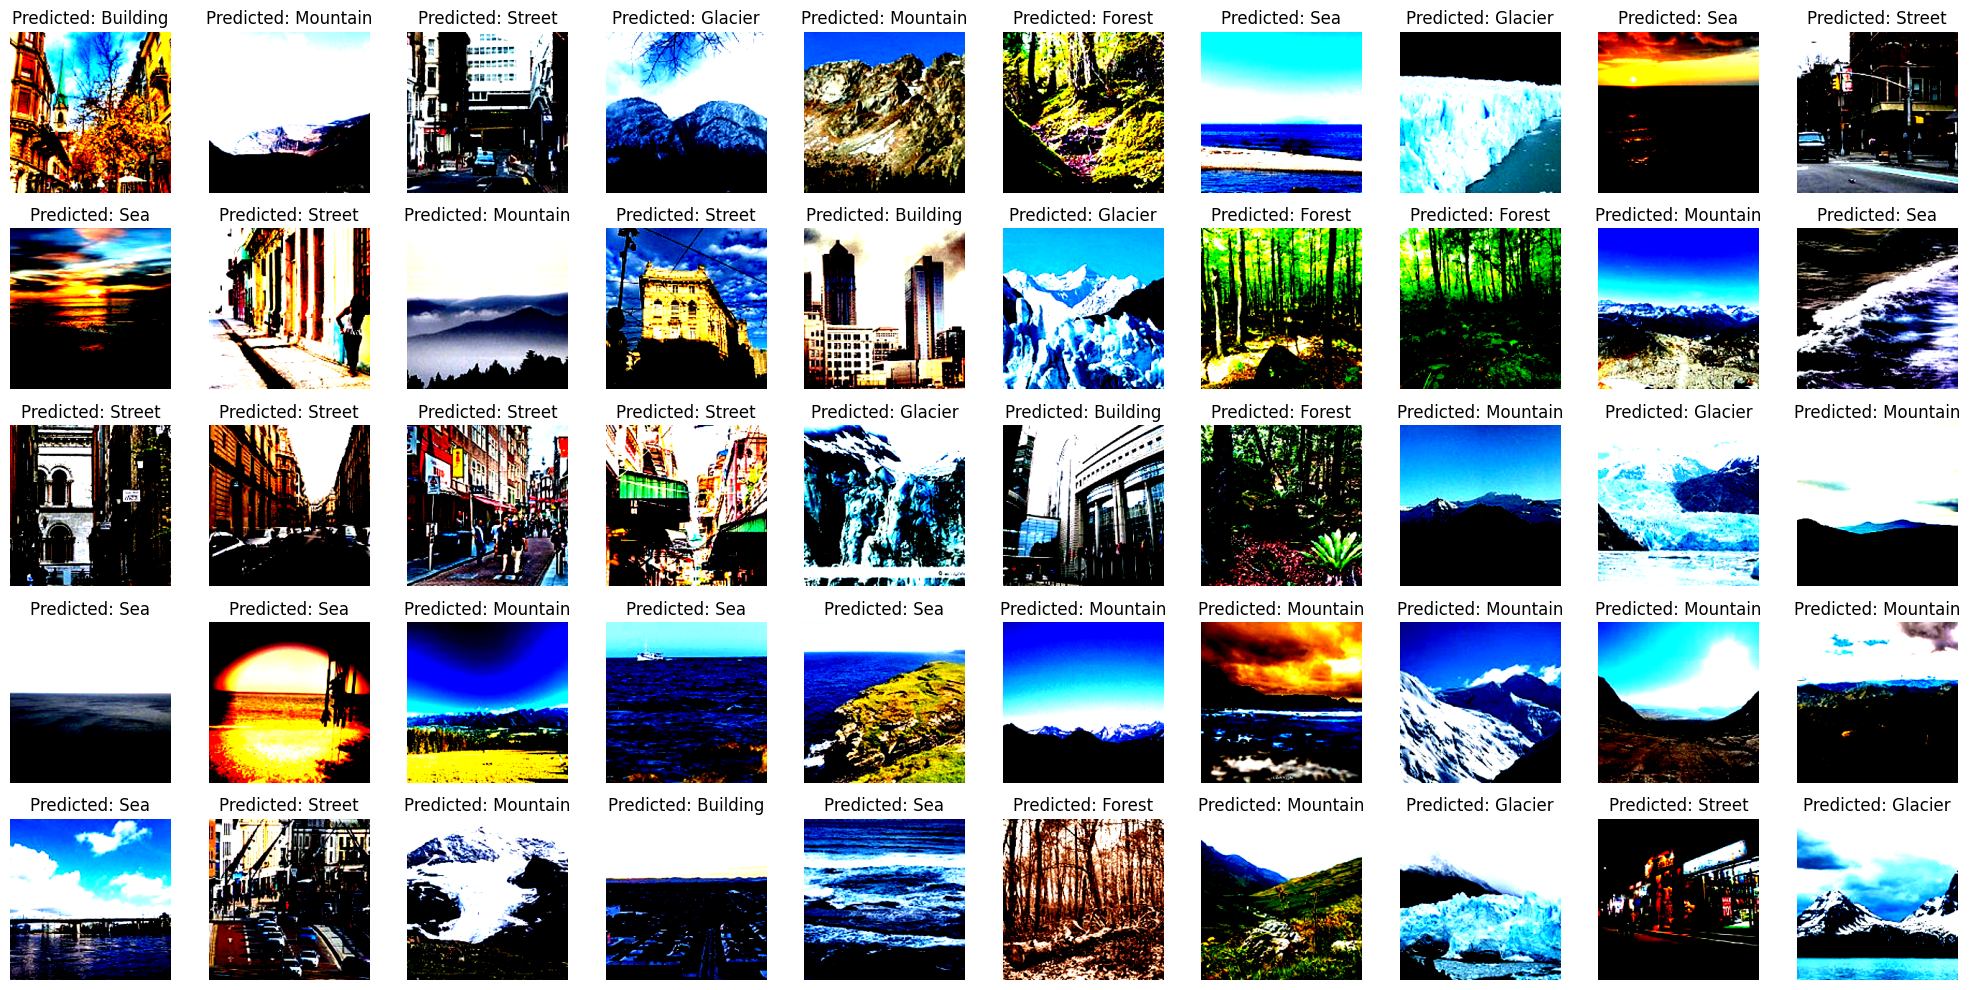

In [15]:
show_predictions(predict_dataloader, model, num_images=50)